In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


# Users params
random_state_users = 42
n_samples_users = 1000
n_features_users = 10
n_clusters_users = 5


# Create random clusters of users
user_X, user_y = make_blobs(
    n_samples=n_samples_users,
    n_features=n_features_users,
    centers=n_clusters_users,
    random_state=random_state_users
)


# Items params
random_state_items = 12
n_samples_items = 3000
n_features_items = 10
n_clusters_items = 10


# Create random clusters of items
item_X, item_y = make_blobs(
    n_samples=n_samples_items,
    n_features=n_features_items,
    centers=n_clusters_items,
    random_state=random_state_items
)


# Decide what the users like in terms
# of items. E.g. users in cluster 1 like
# "most of the time" items in cluster 3
print("user_X[:1]", user_X[:1])
print("user_y[:1]", user_y[:1])
print("item_X[:1]", item_X[:1])
print("item_y[:1]", item_y[:1])


# Then create an interaction table
# where "most of the time" users
# like their respective items

# Example "14" means user cluster
# "1" likes item cluster "4" etc.
clusters_who_like_each_other = [ "11", "14", "21", "32", "22", "37"]

import random

def check_first_digit(num, clusters_who_like_each_other):
    num_str = str(num)
    
    # generate a random starting index
    start_index = random.randint(0, len(clusters_who_like_each_other) - 1)
    
    # iterate over the cluster_friends list starting at the random index
    for i in range(len(clusters_who_like_each_other)):
        cluster_friends = clusters_who_like_each_other[(start_index + i) % len(clusters_who_like_each_other)]
        if cluster_friends.startswith(num_str):
            # If the cluster_friends matches, return the second digit of the cluster_friends as an integer
            return int(cluster_friends[1])
    
    # If no match is found, return None
    return None


# Then create an interaction table
# where "most of the time" users
# like their respective items
interaction_results = []

users_X_with_features = []
items_X_with_features = []

random_interactions_count = 100


for i in range(random_interactions_count):
    random_number_user = np.random.randint(0, n_samples_users + 1)
    random_number_item = np.random.randint(0, n_samples_items + 1)
    curr_user_cluster = user_y[random_number_user]
    curr_item_cluster = item_y[random_number_item]
    # print(user_y)


    user_item = str(random_number_user) + "-" + str(random_number_item)
    users_X_with_features.append(user_X[random_number_user])
    items_X_with_features.append(item_X[random_number_user])
    lookup = str(curr_user_cluster) + str(curr_item_cluster)
    is_match = True if lookup in clusters_who_like_each_other else False
    insert = (user_item, is_match)
    interaction_results.append(is_match)


    # print("curr_user_cluster", curr_user_cluster)
    # print("curr_item_cluster", curr_item_cluster)
    # print("lookup", lookup)
    # print("is_match", is_match)

# print("interactions", interaction_results)
# print("users_X_with_features", users_X_with_features)
# print("items_X_with_features", items_X_with_features)
users_X_tensor = torch.tensor(users_X_with_features, dtype=torch.float32)
items_X_tensor = torch.tensor(items_X_with_features, dtype=torch.float32)
labels = torch.tensor(interaction_results, dtype=torch.float32).view(-1, 1)
# print(labels)
# print("users_X_tensor", users_X_tensor)
# print("items_X_tensor", items_X_tensor)
 
def get_item_cluster_ids_from_user_ids(similar_user_ids, clusters_who_like_each_other, user_y):
  item_clusters = []
  for user_id in similar_user_ids: 
    user_cluster_number = user_y[user_id] + 1
    print("user_cluster_number", user_cluster_number)
    item_cluster_number = check_first_digit(user_cluster_number, clusters_who_like_each_other)
    print("item_cluster_number", item_cluster_number)
    item_clusters.append(item_cluster_number)
  return item_clusters
 


user_X[:1] [[ 2.85082875 -6.83466693 -3.98953692 -1.51050354 -1.41819154  6.59842978
  -7.63853924 -0.62025906  0.04124998 -9.34583705]]
user_y[:1] [2]
item_X[:1] [[ 4.47657725 -8.85703514 -7.75386124 -6.62076787 -3.59785388  3.85447818
  -0.9444756   5.5470049  -2.98305105  4.54326568]]
item_y[:1] [2]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class UserTower(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(UserTower, self).__init__()
        self.tower = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(), # activation function
            nn.Linear(128, embedding_dim),
        )

    def forward(self, input):
        return self.tower(input)


class ItemTower(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(ItemTower, self).__init__()
        self.tower = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),  # activation function
            nn.Linear(128, embedding_dim),
        )

    def forward(self, input):
        return self.tower(input)


class TwoTowerNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(TwoTowerNetwork, self).__init__()
        self.tower_a = UserTower(input_dim, embedding_dim)
        self.tower_b = ItemTower(input_dim, embedding_dim)

    def forward(self, input_a, input_b):
        user_embedding = self.tower_a(input_a)
        item_embedding = self.tower_b(input_b)
        return user_embedding, item_embedding

# Initialize the two-tower network and optimizer
embedding_dim = 3
model = TwoTowerNetwork(n_features_items, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Define the binary cross-entropy loss function
loss_function = nn.BCELoss()


# Train the two-tower network
epochs = 100
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass through the two-tower network
    user_embedding, item_embedding = model(users_X_tensor, items_X_tensor)
    # Compute the dot product
    dot_product = torch.matmul(user_embedding, item_embedding.T).diag().view(-1, 1)
    # Convert the dot product to a probability using the sigmoid function
    probability = torch.sigmoid(dot_product)
    # Compute the loss between the predicted probability and the true labels
    loss = loss_function(probability, labels)
    # Backpropagation
    loss.backward()
    # Update the weights
    optimizer.step()
    # Print the loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


# Save the model to disk
torch.save(model.state_dict(), "model.pth")


# Load the model weights from disk and initialize the model
checkpoint = torch.load("model.pth")
m = model.load_state_dict(checkpoint)


# Predict the embeddings for each user and item
# users = torch.randn(10, 5)
# items = torch.randn(10, 5)
# users_embedding, item_embedding = model(users, items)
# print("users_embedding", users_embedding)
# print("item_embedding", item_embedding)


# Pick a user and with cosine similarity find the most similar user
# user = users[0]
# cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# similarity = cos(users_embedding, user)
# print("similarity", similarity)

Epoch 1/100, Loss: 1.0845794677734375
Epoch 2/100, Loss: 1.1072564125061035
Epoch 3/100, Loss: 0.7489565014839172
Epoch 4/100, Loss: 1.1980502605438232
Epoch 5/100, Loss: 0.7229579091072083
Epoch 6/100, Loss: 0.6783252954483032
Epoch 7/100, Loss: 0.42862167954444885
Epoch 8/100, Loss: 0.27537932991981506
Epoch 9/100, Loss: 0.2128629833459854
Epoch 10/100, Loss: 0.24369312822818756
Epoch 11/100, Loss: 0.2563185691833496
Epoch 12/100, Loss: 0.21760734915733337
Epoch 13/100, Loss: 0.20068439841270447
Epoch 14/100, Loss: 0.16703368723392487
Epoch 15/100, Loss: 0.10592648386955261
Epoch 16/100, Loss: 0.08612173050642014
Epoch 17/100, Loss: 0.0816958025097847
Epoch 18/100, Loss: 0.07511381804943085
Epoch 19/100, Loss: 0.062313128262758255
Epoch 20/100, Loss: 0.06367338448762894
Epoch 21/100, Loss: 0.05889788269996643
Epoch 22/100, Loss: 0.045637935400009155
Epoch 23/100, Loss: 0.03588452190160751
Epoch 24/100, Loss: 0.02928883582353592
Epoch 25/100, Loss: 0.03178228437900543
Epoch 26/100, Lo

user_embedding shape torch.Size([100, 3])


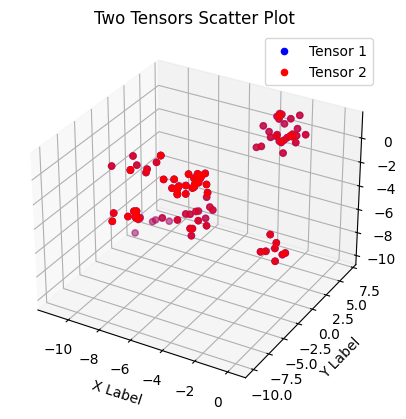

In [ ]:
# Predict the embeddings for each user and item
# users = torch.randn(embedding_dim, 5)
# items = torch.randn(embedding_dim, 5)
# user_embedding, item_embedding = model(random_interactions_count, random_interactions_count)
# print("user_embedding", user_embedding)
print("user_embedding shape", user_embedding.shape)
# print("item_embedding", item_embedding)


# convert tensors to numpy arrays
user_embedding_numpy = user_embedding.detach().numpy()
user_embedding_numpy = item_embedding.detach().numpy()

# extract x, y, and z values from the tensors
x1 = user_embedding_numpy[:, 0]
y1 = user_embedding_numpy[:, 1]
z1 = user_embedding_numpy[:, 2]

x2 = user_embedding_numpy[:, 0]
y2 = user_embedding_numpy[:, 1]
z2 = user_embedding_numpy[:, 2]

# plot the scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, y1, z1, color='blue', label='Tensor 1')
ax.scatter(x2, y2, z2, color='red', label='Tensor 2')

# set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Two Tensors Scatter Plot')
ax.legend()

# show the plot
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between items in user_embedding
similarity_matrix = cosine_similarity(user_embedding_numpy)

# Find the items that are closest to the first item in user_embedding
similar_items_indices = np.argsort(similarity_matrix[0])[::-1][1:6]
print(similarity_matrix)

# Print the indices and cosine similarity scores of the similar items
print(similarity_matrix.shape)
# for idx in similar_items_indices:
#     print(f"User {idx}: Similarity score = {similarity_matrix[0, idx]}")

def find_similar_users(user_index, similarity_matrix):
  similar_user_ids = [user_index]
  similar_users_indices = np.argsort(similarity_matrix[user_index])[::-1][1:6]
  for idx in similar_users_indices:
    print(f"User {idx}: Similarity score = {similarity_matrix[user_index, idx]}")
    similar_user_ids.append(idx)
  return similar_user_ids

similar_user_ids = find_similar_users(10, similarity_matrix)
print(similar_user_ids)

item_cluster_ids = get_item_cluster_ids_from_user_ids(similar_user_ids, clusters_who_like_each_other, user_y)
print(item_cluster_ids)
  

clusters_who_like_each_other = { "11", "14", "21", "32", "22", "37"}

[[ 0.9999999  -0.4875128  -0.2702766  ...  0.99087536  0.43156046
  -0.5109757 ]
 [-0.4875128   1.          0.9693065  ... -0.52585405 -0.4269535
   0.99269164]
 [-0.2702766   0.9693065   0.99999994 ... -0.3044872  -0.28318053
   0.94545084]
 ...
 [ 0.99087536 -0.52585405 -0.3044872  ...  1.          0.5486741
  -0.5626955 ]
 [ 0.43156046 -0.4269535  -0.28318053 ...  0.5486741   0.9999999
  -0.53291845]
 [-0.5109757   0.99269164  0.94545084 ... -0.5626955  -0.53291845
   1.        ]]
(100, 100)
User 3: Similarity score = 0.9984619617462158
User 28: Similarity score = 0.9933696389198303
User 86: Similarity score = 0.9928857088088989
User 61: Similarity score = 0.9916895031929016
User 71: Similarity score = 0.9904030561447144
[10, 3, 28, 86, 61, 71]
user_cluster_number 2
item_cluster_number 1
user_cluster_number 4
item_cluster_number None
user_cluster_number 2
item_cluster_number 2
user_cluster_number 3
item_cluster_number 2
user_cluster_number 2
item_cluster_number 1
user_cluster_number